# Attention Model Pipeline

In [78]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from TrainValTensorBoard import TrainValTensorBoard
import matplotlib.pyplot as plt
from scipy import signal

pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'1.13.1'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [14]:
df = pd.read_csv('/nfs/2018/j/jcruz-y-/neurotron_datasets/joined/joined_data_106979_24-Oct-19_17:31_jose_all_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [15]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571891e+09,0.006226,1.571891e+09,50.0,250.0,396.0,89.0,53.0,43.0,31.0,61.0,9.262085,-9.118690,47.617905,-18.114399,-8.678528,51.673462,-46.709621,-12.567474,17.094170,-69.877258,-11.163055,-3.096992,-85.138763,-10.990265,-17.690151,-20.603283,15.033867,-19.298096,-18.594982,29.675285,-55.134228,-23.628544,21.952751,-74.898529,-29.280987,9.089638,-81.241966,-1.600807,9.199806,-21.184177,9.602978,22.597313,-61.013245,5.366776,12.613152,-84.265617,-2.429310,-1.073235,-90.542023,16.659401,0.454193,-17.607121,31.992260,15.967636,-51.509766,30.006121,9.053932,-75.447060,22.099865,-3.387665,-83.625824,31.320591,-11.242180,-12.971455,48.320904,0.762253,-37.152554,49.054413,-1.940414,-54.576313,42.004250,-10.960121,-65.103134
1,1.571891e+09,-0.029152,1.571891e+09,50.0,286.0,368.0,74.0,51.0,29.0,23.0,42.0,6.786233,-11.333852,47.534789,-20.769446,-11.812599,49.990927,-48.818829,-12.573416,14.808353,-71.526649,-9.472275,-5.685904,-86.040143,-8.497499,-20.978106,-19.892583,15.473871,-19.684725,-16.363919,31.977931,-54.562784,-20.061439,25.205292,-74.945980,-24.964155,12.585976,-82.297033,-0.656441,10.240284,-20.741277,12.169991,25.430847,-59.404511,9.774177,16.861857,-83.445555,3.000662,3.609998,-91.510464,17.612489,1.798022,-16.543760,34.630843,19.197273,-48.656146,34.708936,13.781877,-73.032392,28.021311,1.851053,-82.843496,32.317179,-9.737174,-11.650706,50.569850,3.507205,-34.192403,52.642263,1.569894,-51.594506,46.731619,-7.074512,-63.067226
2,1.571891e+09,0.001225,1.571891e+09,48.0,270.0,347.0,69.0,50.0,29.0,22.0,37.0,5.317806,-12.499672,47.453987,-22.304150,-13.473961,48.934364,-50.567093,-11.620216,13.915695,-73.125786,-7.157860,-6.519272,-87.022034,-5.696548,-22.351597,-19.449600,15.688126,-19.963085,-15.181034,33.082428,-54.341133,-18.064960,27.075287,-75.106461,-22.477337,14.810486,-83.337776,-0.101135,10.783897,-20.485744,13.475960,26.486450,-58.701767,12.304794,18.931656,-83.193710,6.364304,6.209526,-92.698830,18.149715,2.515739,-15.874870,36.093548,20.546936,-47.148628,37.534588,16.020477,-71.687836,31.792110,4.564583,-82.641403,32.863037,-8.918983,-10.774841,52.029774,4.644127,-32.373928,55.188416,3.101257,-49.667633,50.315052,-5.215370,-61.872467
3,1.571891e+09,0.009088,1.571891e+09,49.0,245.0,326.0,66.0,39.0,28.0,23.0,36.0,5.141285,-12.493469,47.475067,-22.483795,-13.559532,48.828407,-50.828781,-11.390457,13.894257,-73.361900,-6.804001,-6.541451,-87.106232,-5.372879,-22.508564,-19.409599,15.628494,-20.048607,-15.110043,33.002945,-54.432831,-17.841034,27.203735,-75.277794,-22.137730,15.102798,-83.807457,-0.042805,10.788460,-20.483543,13.552137,26.346481,-58.752304,12.602261,18.943726,-83.300186,6.865059,6.356377,-93.104897,18.213963,2.579636,-15.790806,36.240501,20.540024,-47.057739,37.922184,16.111511,-71.599510,32.396820,4.750542,-82.761627,32.941494,-8.807564,-10.625877,52.218910,4.702339,-32.159714,55.573746,3.183128,-49.418533,50.933563,-5.084938,-61.746620
4,1

In [16]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [17]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000
mean,107.959076,277.776554,293.447060,112.697202,55.729031,72.685406,82.720188,67.966208,-1.519532,-9.021946,44.597009,-24.352507,-18.957473,39.809937,-35.202575,-26.591242,2.103636,-40.789788,-32.012339,-22.847791,-44.154327,-35.382372,-37.740631,-16.995893,7.373415,-23.683015,-14.404202,3.981787,-54.751712,-13.055133,-3.578775,-67.611467,-12.313513,-10.208400,-73.972310,0.712549,9.388218,-19.306369,9.581468,4.679483,-53.065222,12.692946,-4.684326,-67.946889,13.756485,-12.317275,-74.908446,17.529791,8.095233,-10.276684,25.648988,-0.778659,-40.999281,27.275005,-12.593958,-54.669632,27.006531,-21.898478,-60.856092,32.352225,2.837640,-1.285509,41.970822,-4.485664,-24.370822,43.496761,-12.840841,-34.176921,42.845118,-21.385414,-40.369203
std,94.478903,183.819378,181.553457,80.348375,68.751875,110.614351,137.870160,103.867191,18.203014,13.902148,5.902738,17.833762,17.313549,12.854626,10.539880,13.674356,17.937670,20.180079,18.120903,22.667319,30.208039,23.253477,26.870641,9.447936,7.232516,7.711189,22.331166,23.019437,11.387768,28.566881,33.673159,18.030049,32.359781,40.269171,25.337680,8.255159,6.050276,3.587558,22.631948,25.144259,10.117039,30.242326,37.583324,18.901129,34.760672,44.641463,27.063839,5.532313,7.853489,8.013560,18.961775,22.917322,13.537246,27.110144,33.080043,21.107323,32.277698,38.685426,28.408468,4.083498,11.077100,13.504016,14.765910,20.311902,18.142483,21.859076,26.318486,21.132027,28.005897,30.720860,25.151496
min,18.000000,20.000000,22.000000,20.000000,17.000000,16.000000,15.000000,15.000000,-49.460617,-51.661484,-8.476379,-59.220070,-58.296936,-27.315063,-70.195053,-71.954811,-49.751572,-92.561234,-90.297638,-74.886850,-112.754237,-103.504150,-94.854360,-35.338264,-31.792175,-35.444645,-69.852450,-67.396919,-74.289215,-85.011714,-87.236955,-96.546054,-97.884471,-102.978952,-112.462585,-24.145329,-21.980112,-25.657837,-54.249256,-65.532608,-72.724304,-75.109543,-91.424866,-100.599316,-91.211243,-109.174942,-118.985

In [18]:
def preprocess_features(x_train):
    shape = (7, 13, 8)
    reshape = (-1, shape[0], shape[1], shape[2])
    x_train = x_train.replace(-np.inf, 0)
    x_train = x_train.replace(np.inf, 0)
    #x_train = np.log(x_train.values)
    x_train = x_train.values
    x_train_norm = x_train.reshape(reshape)
    return x_train_norm

#features = preprocess_features(df)

In [19]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values
label_ar_tips = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_tips.shape

(106979, 18)

In [20]:
feature_ar.shape

(106979, 8)

In [21]:
label_ar.shape

(106979, 63)

In [22]:
seq_length = 24

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
features, labels_tips = overlap_samples(seq_length, feature_ar, label_ar_tips)
print(features.shape)
print(labels.shape)

(106956, 24, 8)
(106956, 63)


## Attention Basics
[attention mechanism from scratch](https://towardsdatascience.com/learning-attention-mechanism-from-scratch-f08706aaf6b6)

### Attention scoring

#### Inputs to the scoring function

Start by looking at the inputs we'll give to the scoring function.
We will assume we're in the first step in the decoding phase.
First input to scoring function is hidden state of decoder.
Assuming a toy RNN with three hidden nodes -- not usable in real life but easier to illustrate

### decoder hidden state vector

In [18]:
dec_hidden_state = [5, 1, 20] # Decoder hidden state (query vector?)

Visualize this vector

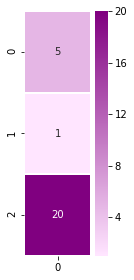

In [19]:
import seaborn as sns
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

### Encoder hidden state = annotation

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [20]:
annotation = [3, 12, 45] # i.e. Encoder hidden state

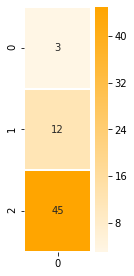

In [21]:
# Visualizing single annotation
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True,
            cmap=sns.light_palette("orange",as_cmap=True), linewidths=1)

### Scoring a single annotation
dot product of decoder hidden state and encoder hidden state

In [22]:
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    return np.dot(dec_hidden_state, enc_hidden_state)

single_dot_attention_score(dec_hidden_state, annotation)

927

### Annotations Matrix
All the scoring of annotations at once. To do that, here's annotation matrix

In [23]:
annotations = np.transpose([[3, 12, 45], [59, 2, 5], [1, 43, 5], [4, 3, 45.3]])

It can be visualized like this (each column is a hidden state of an encoder time step):

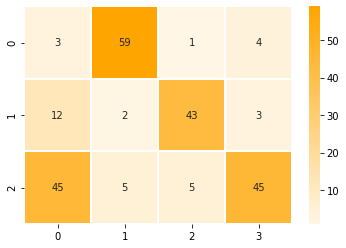

In [24]:
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### Implement: Scoring all annotations at once


In [25]:
def dot_attention_score(dec_hidden, annotations):
    return np.matmul(np.transpose(dec_hidden_state), annotations)

attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([927., 397., 148., 929.])

Looking at these scores the 929 will get the most attention from the decoder


### Softmax
After getting scores we apply softmax

In [26]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0)

attention_weights = softmax(attention_weights_raw)
attention_weights.shape

(4,)

Its good to appreciate again, even after knowing which annotation will get the most focus, 
just how much more drastic the softmax makes the difference.
The first and last annotation had 927 and 929 after the softmax they get .119 and .880 respectively
Even a variation of less than 1% ((1 - 929/927)*100) gets incremented to a variation of 800% ((1 - 929/927)*100)!

### Applying the scores back on the annotations
Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

In [27]:
def apply_attention_scores(attention_weights, annotations):
    return attention_weights * annotations

applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

Now let's see how the context vector looks now

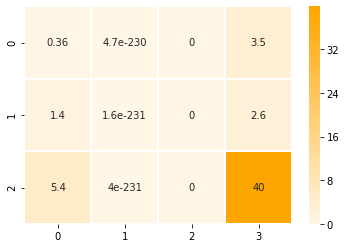

In [28]:
# Visualizing annotations after applying attention
ax = sns.heatmap(applied_attention, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1, annot=True)

Contrasting this with the original annotations matrix and the second and third column have been reduced 
greatly

### Calculating Attention Context Vector
All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector.<br>

In [29]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

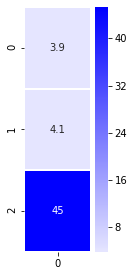

In [30]:
# Visualizing attention context vector
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), cmap=sns.light_palette("blue", as_cmap=True), linewidths=1, annot=True)

### Attention
**This model will incorporate a component of attention**


### Model from phillip peremy
https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py
Attention vector

Also, sometimes the time series can be N-dimensional. It could be interesting to have one atention vector per dimension. Let's

Attention can just then be a softmax applied to an output of something?

The permute function switches the positions of the axis and the dims argument tells how you want the final positions to be.

For example, if x is 4-dimensional and of the shape (None, 2, 4, 5, 8) - (None is the batch size here) and if you specify dims = (3, 2, 1, 4), then the following four steps will take place:

1. Third dimension will move to first
2. Second dimension will move to second
3. First dimension will move to third
4. Fourth dimension will move to fourth

Remember, the indexing starts at 1 and not 0. The dimension zero is the batch size. So finally the output

**RepeatVector**
Repeats the input vector n times



Updated version:
https://github.com/philipperemy/keras-attention-mechanism/issues/14

In [23]:


def attention_3d_block_2(hidden_states):
    # hidden_states.shape = (batch_size, time_steps, hidden_size)
    hidden_size = int(hidden_states.shape[2])
    # Inside dense layer hidden_states dot W => score_first_part
    # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    # W is the trainable weight matrix of attention
    # Luong's multiplicative style score
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    #  score_first_part dot last_hidden_state => attention_weights
    # (batch_size, time_steps, hidden_size) dot (batch_size, hidden_size) => (batch_size, time_steps)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector
    #return pre_activation

In [92]:
INPUT_DIM = 8
TIME_STEPS = 24
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = True
APPLY_ATTENTION_BEFORE_LSTM = False


def attention_3d_block_cnn(inputs,timesteps):
    input_dim = int(inputs.shape[2])
    time_steps=timesteps
    a_probs = Conv1D(input_dim,3,strides=1,padding='same',activation='softmax')(inputs)
    output_attention_mul= Multiply()([inputs, a_probs]) #name='attention_mul'
    return output_attention_mu

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs) # changes the order of the parameters (in this case 2 becomes 1 and 1 becomes 2)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a) #, name='attention_vec')(a)
    output_attention_mul = Add()([a_probs, inputs])
    return output_attention_mul

def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    
    lstm_units = 40
    
    model = LSTM(lstm_units, return_sequences=True)(inputs)
    model = Dropout(0.3)(model)
    model = BatchNormalization()(model)
    model = attention_3d_block(model)
    #model = LSTM(lstm_units, return_sequences=True)(model)
    #model = attention_3d_block_cnn()(model)
    
    model = LSTM(lstm_units, return_sequences=True)(model)
    model = Dropout(0.3)(model)
    model = BatchNormalization()(model)
    model = attention_3d_block(model)
    
    model = Flatten()(model)
    output = Dense(63, activation=None)(model)
    model = Model(inputs, output)
    return model

model = model_attention_applied_after_lstm()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 24, 8)        0                                            
__________________________________________________________________________________________________
lstm_41 (LSTM)                  (None, 24, 40)       7840        input_27[0][0]                   
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 24, 40)       0           lstm_41[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_21 (Batc (None, 24, 40)       160         dropout_23[0][0]                 
__________________________________________________________________________________________________
permute_28

In [93]:
optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=True)
model.compile(optimizer=optimizer, loss='mse')

In [95]:
model.evaluate(features, labels, verbose=1)

106956/106956 [==============================] - 41s 383us/sample - loss: 1553.1603


1553.1602660580418

### Attention shared
val loss = 430

In [96]:
history = model.fit(features, labels, epochs=40, verbose=1, validation_split=0.2, callbacks=[TrainValTensorBoard()])

Train on 85564 samples, validate on 21392 samples
Epoch 1/40
85564/85564 [==============================] - 118s 1ms/sample - loss: 361.9699 - val_loss: 514.5101
Epoch 2/40
85564/85564 [==============================] - 125s 1ms/sample - loss: 306.6589 - val_loss: 429.1403
Epoch 3/40
85564/85564 [==============================] - 121s 1ms/sample - loss: 286.3154 - val_loss: 443.1745
Epoch 4/40
85564/85564 [==============================] - 121s 1ms/sample - loss: 275.4276 - val_loss: 524.1820
Epoch 5/40
85564/85564 [==============================] - 119s 1ms/sample - loss: 268.7602 - val_loss: 433.6133
Epoch 6/40
85564/85564 [==============================] - 118s 1ms/sample - loss: 264.2084 - val_loss: 449.7018
Epoch 7/40
85564/85564 [==============================] - 118s 1ms/sample - loss: 258.4215 - val_loss: 422.5237
Epoch 8/40
85564/85564 [==============================] - 118s 1ms/sample - loss: 262.3262 - val_loss: 478.1697
Epoch 9/40
85564/85564 [==============================

KeyboardInterrupt: 

In [42]:
model.save('Attention_jose_all_loss400_vloss500_model.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.title('Attention')

In [37]:
preds = model.predict(features)

In [38]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

ValueError: operands could not be broadcast together with shapes (4977,63) (4977,18) 